## Goal

With this project we will try to train a neural network to predict whether the Indian stock market closing index Nifty will rise or fall on a particular date, based on historical values (1/1/2017 to 17/5/2019).

Other than the standard OHLC (Open, High, Low, Close) data obtained from the National Stock Exchange(NSE), we will calculate a number of market indiactor to improve the accuracy of the model. 

#### 1.Ultimate Oscillator (UO)
#### 2. Ulcer Index (UI)
#### 3. Pring's know sure thing (KST)
#### 4. Relative Vigour Index (RVI)
#### 5. Positive Volume Index (PVI)
#### 6. Market Facilitation Index (MFI)
#### 7. Intraday Momentum Oscillator (IMI)
#### 8. Elder's Force Index (EFI)
#### 9. Detrended Price Oscillator (DPO)
#### 10. Chande Momentum Oscillator (CMO)
#### 11. Aroon Oscillator (AO)
#### 12. Fisher Transformation (FT)
#### 13. Mcginley Dynamic (McD)
#### 14. Return On Interest (ROI) 
#### 15. Relative Strength Index (RSI)
#### 16. Exponential Moving Average (EMA)
#### 17. Moving Average Convergence and Divergence (MACD)
#### 18. Stochastic Relative Strength Index (SRSI)
#### 19. Williams %R Oscillator (Williams)
#### 20. Average True Range (ATR)
#### 21. Commodity Channel Index (CCI)

How the value of each indicator is calculated has been explained below.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import date
from nsepy import get_history
import matplotlib.pyplot as plt
%matplotlib inline
import functools
import math
from sklearn import preprocessing as pp

# Step 1: Prepare data

# Load data
Load data using the NSEpy API

In [2]:
data = get_history(symbol="NIFTY", start=date(2017,1,1), end=date(2019,5,17), index = True)

In [3]:
print(data.head())

               Open     High      Low    Close     Volume      Turnover
Date                                                                   
2017-01-02  8210.10  8212.00  8133.80  8179.50  122016111  5.255490e+10
2017-01-03  8196.05  8219.10  8148.60  8192.25  131186021  6.053670e+10
2017-01-04  8202.65  8218.50  8180.90  8190.50  136476345  6.543130e+10
2017-01-05  8226.65  8282.65  8223.70  8273.80  163957452  8.180680e+10
2017-01-06  8281.85  8306.85  8233.25  8243.80  143689850  7.298740e+10
               Open     High      Low    Close     Volume      Turnover
Date                                                                   
2017-01-02  8210.10  8212.00  8133.80  8179.50  122016111  5.255490e+10
2017-01-03  8196.05  8219.10  8148.60  8192.25  131186021  6.053670e+10
2017-01-04  8202.65  8218.50  8180.90  8190.50  136476345  6.543130e+10
2017-01-05  8226.65  8282.65  8223.70  8273.80  163957452  8.180680e+10
2017-01-06  8281.85  8306.85  8233.25  8243.80  143689850  7.298

In [4]:
data.describe()

,Open,High,Low,Close,Volume,Turnover
count,587.000000,587.000000,587.000000,587.000000,5.870000e+02,5.870000e+02
mean,10333.968569,10371.572743,10279.540290,10326.231687,2.570281e+08,1.309764e+11
std,811.725487,815.555543,801.815012,808.183431,9.588361e+07,4.388493e+10
min,8196.050000,8212.000000,8133.800000,8179.500000,3.108638e+07,1.534080e+10
25%,9882.775000,9904.500000,9834.525000,9872.950000,1.906996e+08,9.881730e+10
50%,10464.850000,10503.600000,10412.550000,10458.350000,2.334096e+08,1.226766e+11
75%,10851.125000,10891.300000,10786.100000,10833.400000,3.047829e+08,1.542600e+11
max,11856.150000,11856.150000,11738.500000,11787.150000,7.411532e+08,3.513119e+11


,Open,High,Low,Close,Volume,Turnover
count,587.000000,587.000000,587.000000,587.000000,5.870000e+02,5.870000e+02
mean,10333.968569,10371.572743,10279.540290,10326.231687,2.570281e+08,1.309764e+11
std,811.725487,815.555543,801.815012,808.183431,9.588361e+07,4.388493e+10
min,8196.050000,8212.000000,8133.800000,8179.500000,3.108638e+07,1.534080e+10
25%,9882.775000,9904.500000,9834.525000,9872.950000,1.906996e+08,9.881730e+10
50%,10464.850000,10503.600000,10412.550000,10458.350000,2.334096e+08,1.226766e+11
75%,10851.125000,10891.300000,10786.100000,10833.400000,3.047829e+08,1.542600e+11
max,11856.150000,11856.150000,11738.500000,11787.150000,7.411532e+08,3.513119e+11


In [5]:
data.dtypes

Open        float64
High        float64
Low         float64
Close       float64
Volume        int64
Turnover    float64
dtype: object

Open        float64
High        float64
Low         float64
Close       float64
Volume        int64
Turnover    float64
dtype: object

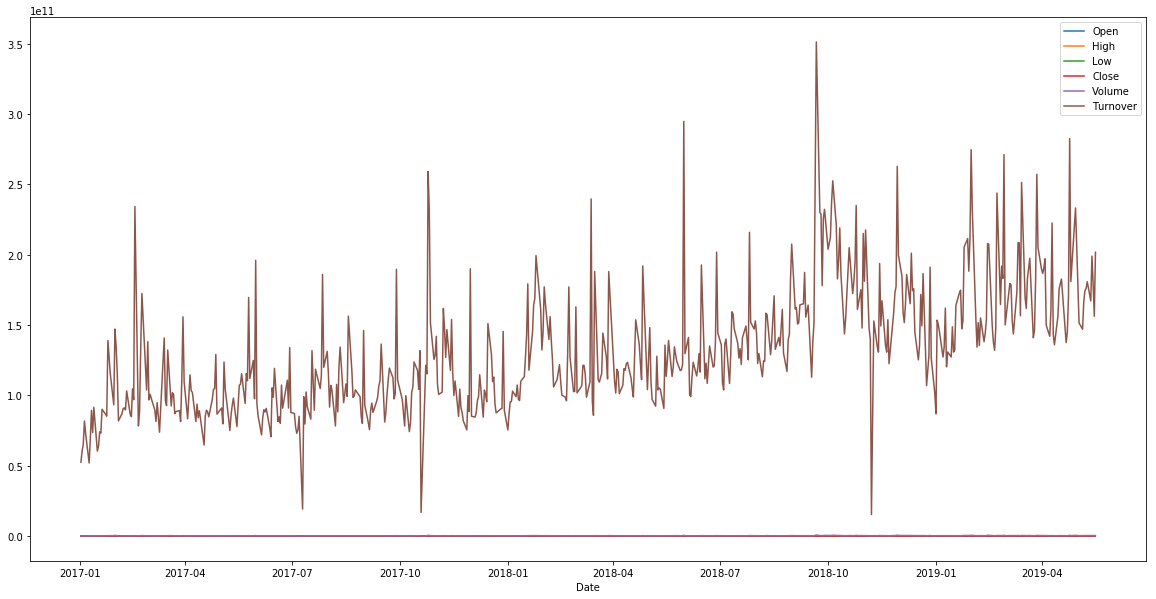

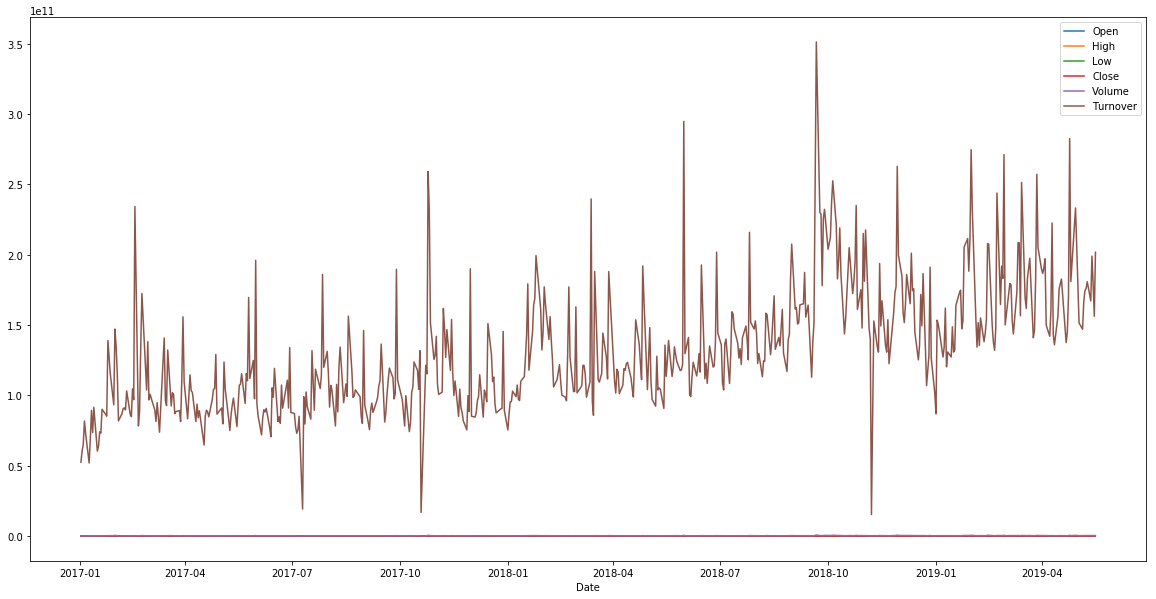

In [6]:
# observe data in graph
data.plot(figsize=(20,10))

# Calculating the Indicators

In [7]:
def sum_bp_n(data,n,i): #calculates the sum of Buying Pressure over the last 7 days
    arr = []
    for j in range(0,n):
        bp = data.Close[i-j] - min(data.Low[i-j],data.Close[i-j-1])
        arr.append(bp)
    return sum(arr)

In [8]:
def sum_tr_n(data,n,i): #calculates the sum of True Range over the last 7 days
    arr = []
    for j in range(0,n):
        tr = max(data.High[i-j],data.Close[i-j-1]) - min(data.Low[i-j],data.Close[i-j-1])
        arr.append(tr)
    return sum(arr)

## Ultimate Oscillator

Buying Pressure (BP) = Close - Min {Low, Prev Close}
True Range (TR) = Max {High, Prev Close} - Min {Low, Prev Close}

AV7 = Sum of BP over last 7 days / Sum of TR for last 7 days 
AV14 = Sum of BP over last 14 days / Sum of TR for last 14 days 
AV28 = Sum of BP over last 28 days / Sum of TR for last 28 days

#### Ultimate Oscillator (UO) = [( AV7*4 + AV14*2 + AV28*1) / (4 + 2 + 1)]

sum_bp_n and sum_tr_n are functions used to calculate the Buying Pressure and True Range respectively over a specified range (n)

In [9]:
def ult_Oscill(data):
    n = len(data)
    arr = []
    
    for i in range(0,27):
        arr.append('N')
    
    for i in range(27,n):
        
        bp_7 = sum_bp_n(data,7,i)
        bp_14 = sum_bp_n(data,14,i)
        bp_28 = sum_bp_n(data,28,i)

        tr_7 = sum_tr_n(data,7,i)
        tr_14 = sum_tr_n(data,14,i)
        tr_28 = sum_tr_n(data,28,i)
        
        av_7 = bp_7/tr_7
        av_14 = bp_14/tr_14
        av_28 = bp_28/tr_28
        
        uo = ( (av_7)*4 + (av_14)*2 + (av_28)*1 )*100/(4+2+1)
        
        arr.append(uo)
    return arr

uo = ult_Oscill(data)
print(len(uo))
data['UO'] = uo

587
587


n_per_High_Close is used to calculate the highest closing price over the previous n periods

In [10]:
def n_per_High_Close(data,n,i): #Highest closing price in previous n days
    arr = []
    for j in range(0,n):
        close = data.Close[i-j]
        arr.append(close)
    return max(arr)

n_per_Sum_pdd is used to calculate the percentage drawdown over n periods 

In [11]:
def n_per_Sum_pdd(data,n,i): #n period sum of Percentage Drawdown
    arr = []
    for j in range(0,n):
        HCls_14 = n_per_High_Close(data,14,i)
        pdd = (data.Close[i-j] - HCls_14)*100/HCls_14 #Percentage Drawdown
        arr.append(pdd)
    return sum(arr)

## Ulcer Index

The indicator is calculated in three steps:

Percentage drawdown = [(Close - 14 Period High of closes) / 14 Period High of Closes] *100
Squared Avg = (14 Period sum of Percentage drawdown) / 14

#### Ulcer Index = SQRT (Squared Avg)

The Ulcer Index is used to determine the downside risk.

In [12]:
def ulc_Index(data):
    n = len(data)
    arr = []
    
    for i in range(0,14):
        arr.append('N')
    
    for i in range(14,n):
        sq_av = n_per_Sum_pdd(data,14,i)/14
        ui = math.sqrt(abs(sq_av))
        arr.append(ui)
    return arr

ui = ulc_Index(data)
#print(len(ui))
data['UI'] = ui

n_per_SMA is used to calculate the Simple Moving Average (SMA) over the last n periods. 
SMA = (A1 + A2 + ... + An)/n, where Ai is the value i periods prior to the current period.
Note that for n_per_SMA and n_per_ROC we have passed seperate arrays instead of using data directly from the dataframe. 

In [13]:
def n_per_SMA(arr,n): 
    sum = 0
    l = len(arr)
    for j in range(0,n):
        sum = sum + arr[l-j-1]
    return (sum/n)

n_per_ROC is used to calculate the Rate of Change. 
ROC = 100*(Close[i]-Close[i-n])/Close[i-n]

In [14]:
def n_per_ROC(arr,n,i):
    arr1 = []
    for j in range(0,n):
        roc = (arr[i-j]-arr[i-j-n])*100/n
        arr1.append(roc) 
    return arr1

## Pring's Know Sure Thing (KST)

#### KST = (RCMA#1*1) + (RCMA#2*2) + (RCMA#3*3) + (RCMA#4*4) where

RCMA#1 = 10 period SMA of 10 period ROC 
RCMA#2 = 10 period SMA of 15 period ROC 
RCMA#3 = 10 period SMA of 20 period ROC 
RCMA#4 = 15 period SMA of 30 period ROC

In [15]:
def KST(data): #Pring's Know Sure Thing
    arr = []
    n = len(data)
    for i in range(0,30):
        arr.append('N')
    for i in range(30,n):
        RCMA_1 = n_per_SMA(n_per_ROC(data.Close.tolist(),10,i),10)
        RCMA_2 = n_per_SMA(n_per_ROC(data.Close.tolist(),15,i),10)
        RCMA_3 = n_per_SMA(n_per_ROC(data.Close.tolist(),20,i),10)
        RCMA_4 = n_per_SMA(n_per_ROC(data.Close.tolist(),30,i),15)
        kst = 1*RCMA_1 + 2*RCMA_2 + 3*RCMA_3 + 4*RCMA_4
        arr.append(kst)
    return arr

arr = KST(data)
data['KST'] = arr 

## Relative Vigor Index (RVI)

In [16]:
def RVI(data): #incomplete
    n = len(data)
    for i in range(3,n):
        a = data.Close[i] - data.Open[i]
        b = data.Close[i-1] - data.Open[i-1]
        c = data.Close[i-2] - data.Open[i-2]
        d = data.Close[i-3] - data.Open[i-3]
        
        e = data.High[i] - data.Low[i]
        f = data.High[i-1] - data.Low[i-1]
        g = data.High[i-2] - data.Low[i-2]
        h = data.High[i-3] - data.Low[i-3]

## Positive Volume Index (PVI)

Helps infer if smart money (institutional investor money) is pouring in / out. 

If today’s volume is ​higher​ than previous day’ volume
PVI = Previous PVI + [(Today’s Close - Prev Close) / Prev Close] * Previous PVI 

ELSE
PVI unchanged


In [17]:
def PVI(data): #Positive Volume Index
    pvi = data.Volume[0] #I'm assuming the base case is the volume on the first day for which data is available. 
    arr = []
    arr.append('N')
    n = len(data)
    for i in range(1,n):
        if data.Volume[i] > data.Volume[i-1]:
            pvi = pvi + ((data.Close[i]-data.Close[i-1])/data.Close[i-1])*pvi
        arr.append(pvi)
    return arr

arr = PVI(data)
data['PVI'] = arr

## Negative Volume Index (NVI)

If today’s volume is ​lower​ than previous day’s volume
NVI = Previous NVI + [(Today’s Close - Prev Close) / Prev Close] * Previous NVI 

ELSE
NVI unchanged

In [18]:
def NVI(data): #Negative Volume Index
    nvi = data.Volume[0] #I'm assuming the base case is the volume on the first day for which data is available. 
    arr = []
    arr.append('N')
    n = len(data)
    for i in range(1,n):
        if data.Volume[i] < data.Volume[i-1]:
            nvi = nvi + ((data.Close[i]-data.Close[i-1])/data.Close[i-1])*nvi
        arr.append(nvi)
    return arr

arr = NVI(data)
data['NVI'] = arr

## Market Facilitation Index

#### MFI = (High - Low) / Volume
Basically price change per unit volume. Note that since volumes are very large MFI is a small value

In [19]:
def MFI(data): #Market Facilitation Index
    arr = []
    n = len(data)
    for i in range(0,n):
        mfi = (data.High[i]-data.Low[i])/data.Volume[i]
        arr.append(mfi)
    return arr

arr = MFI(data)
data['MFI'] = arr

In [20]:
def sum_gains_losses(data,n,i):
    g = []
    l = []
    for j in range(0,n):
        if data.Close[i-j]>data.Close[i-j-1]:
            g.append(data.Close[i-j]-data.Close[i-j-1])
        else:
            l.append(data.Close[i-j-1]-data.Close[i-j])
    sum_gains = sum(g)
    sum_losses = sum(l)
    return sum_gains,sum_losses 

## Intraday Momentum Oscillator

#### IMI = (Sum of Gains over N days) / (Sum of Gains over N days + Sum of losses over N days)

if Close today > Close yesterday Gain = Close today - Close yesterday

Else if Close today < Close yesterday Loss = Close Yesterday - Close today

For now I have taken N as 14 but this can be easily changed
Similar purpose as RSI...incorporates graphical features and trading psychology

In [21]:
def IMI(data): #Intraday Momentum Oscillator
    n = len(data)
    arr = []
    for i in range(0,14):
        arr.append('N')
    for i in range(14,n):
        s_g,s_l = sum_gains_losses(data,14,i) #Change the 14 to X to change period (3 times)
        imi = (s_g)/(s_g+s_l)
        arr.append(imi)
    return arr

arr = IMI(data)
data['IMI'] = arr

## Elder's Force Index
#### Elder’s Force Index = (Close (Today) - Close (Yesterday)) * Today’s Volume

Measures strength of an up move or down move

In [22]:
def EFI(data): #Elder's Force Index
    arr = []
    arr.append('N')
    n = len(data)
    for i in range(1,n):
        efi = (data.Close[i]-data.Close[i-1])*data.Volume[i]
        arr.append(efi)
    return arr
arr = EFI(data)
data['EFI'] = arr

In [23]:
def n_per_SMA(arr,n,i): 
    sum = 0
    for j in range(0,n):
        sum = sum + arr[i-j-1]
    return (sum/n)

## Detrended Price Oscillator

Let us say lookback period is N. Taking as 14 for now

#### DPO = Close (N/2 + 1 periods ago) - SMA of close (Last N periods)

Great for short term / intraday trades as it puts emphasis on short term cycles and filters out the long term trend.

In [24]:
def DPO(data): #Detrended Price Oscillator
    l = 14 #Lookback Period
    n = len(data)
    arr = []
    for i in range(0,l):
        arr.append('N')
    for i in range(l,n):
        sma = n_per_SMA(data.Close,l,i)
        dpo = data.Close[i-((l//2)+1)] - sma
        arr.append(dpo)
    return arr

arr = DPO(data)
data['DPO'] = arr

True Range (TR) = Maximum of 1) High - Low
                             2) Modulus of (High - Previous Close) 
                             3) Modulus of (Low - Previous Close)

In [25]:
def TR(data,i): #True Range 
    a = data.High[i] - data.Low[i]
    b = abs(data.High[i] - data.Close[i-1])
    c = abs(data.Low[i] - data.Close[i-1])    
    tr = max(a,b,c)
    return tr

## Average True Range

#### ATR  = (Summation of TR for past n days) / n

It is a ​volatility measurer ​and is very useful for trading options. Might help in stocks as high ATR generally signifies downtrend.
Taking N as 14 for now.


In [26]:
def n_per_sum_TR(data,n,i): #Calculates the sum of the TR for the past n periods
    arr = []
    for j in range(0,n):
        arr.append(TR(data,i-j))
    return sum(arr)

In [27]:
def n_per_ATR(data,n):
    arr = []
    for i in range(0,n):
        arr.append('N')
    for i in range(n,len(data)):
        sum = n_per_sum_TR(data,n,i)
        atr = sum/n
        arr.append(atr)
    return arr

In [28]:
arr = n_per_ATR(data,14)
data['ATR_14'] = arr

## Chande Momentum Oscillator

#### CMO = [ (sH-sL) / (sH+sL) ] * 100
sH = Sum of higher closes over N periods sL = Sum of lower closes over N periods

In [29]:
def n_per_CMO(data,n): #Chande Momentum Oscillator
    arr = []
    for i in range(0,n):
        arr.append('N')
    for i in range(n,len(data)):
        hc = [] #High Closes in the last n periods. A high close is the close when the closing price is greater than opening price
        lc = [] #Low Closes in the last n periods
        for j in range(0,n):
            if data.Close[i-j]>data.Open[i-j]:
                hc.append(data.Close[i-j])
            else:
                lc.append(data.Close[i-j])
        sH = sum(hc)
        sL = sum(lc)
        cmo = ( (sH-sL)/(sH+sL) )*100
        arr.append(cmo)
    return arr

arr = n_per_CMO(data,14) #Taking N = 14 for now
data['CMO'] = arr

In [30]:
def pers_since_n_per_High_Close(data,n,i): #Periods (days) since highest closing price in previous n days
    arr = []
    for j in range(0,n):
        close = data.Close[i-j]
        arr.append(close)
    for j in range(0,n):
        if float(arr[j]) == max(arr):
            return n-j

In [31]:
def pers_since_n_per_Low_Close(data,n,i): #Periods (days) since lowest closing price in previous n days
    arr = []
    for j in range(0,n):
        close = data.Close[i-j]
        arr.append(close)
    for j in range(0,n):
        if float(arr[j]) == min(arr):
            return n-j

## Aroon Oscillator (Up)

#### Aroon Up = 100 * (n - periods since period high) / 25

In [32]:
def n_per_AO_up(data,n): #n period Aroon Oscillator
    arr = []
    for i in range(0,n):
        arr.append('N')
    for i in range(n,len(data)):
        p_h = pers_since_n_per_High_Close(data,n,i)
        a_up = 100*(n - p_h)/n
        arr.append(a_up)
    return arr

## Aroon Oscillator (Down)
#### Aroon Down = 100 * (25 - periods since 25 period low) / 25

In [33]:
def n_per_AO_down(data,n): #n period Aroon Oscillator
    arr = []
    for i in range(0,n):
        arr.append('N')
    for i in range(n,len(data)):
        p_l = pers_since_n_per_Low_Close(data,n,i)
        a_down = 100*(n - p_l)/n
        arr.append(a_down)
    return arr

In [34]:
aroon_up = n_per_AO_up(data,25)
aroon_down = n_per_AO_down(data,25)

data['AO_up'] = aroon_up
data['AO_down'] = aroon_down

In [35]:
def transform(arr): #transforms the elements of the input array to values between -1 and 1
    arr1 = np.zeros(len(arr))
    for i in range(0,len(arr)):
        arr1[i] = 2*((arr[i]-min(arr))/(max(arr)-min(arr))) - 1
        if float(arr1[i]) == 1.0:
            arr1[i] = 0.9999
        elif float(arr1[i]) == -1.0:
            arr1[i] = -0.9999
    return arr1

## Fisher Transformation

#### Fisher Transform (FT) = 0.5 * ln( (1+X) / (1-X) )
Where ln is natural logarithm and X is transformation of price to a value between -1 and 1. FT converts prices to a Gaussian Normal Distribution helping identify reversals.

In [36]:
def n_per_FT(arr,n): #Fisher Transform
    arr1 = []
    for i in range(0,n):
        arr1.append('N')
    for i in range(n,len(arr)):
        ft = 0.5*(math.log(abs((1+arr[i])/(1-arr[i]))))
        arr1.append(ft)
    return arr1

In [37]:
close_t = data.Close
arr = n_per_FT(transform(close_t),14)
data['FT'] = arr

In [38]:
def WC(data): #Weighted Close 
    arr = []
    n = len(data)
    for i in range(0,n):
        wc = (data.High[i]+data.Low[i]+2*data.Close[i])/4
        arr.append(wc)
    return arr

arr = WC(data)
data['WC'] = arr

## McGinley Dynamic

#### MD = Prev_MD + (Close - Prev_MD) / (K*N*(Close / Prev_MD)4​ ​)
Where

MD = McGinley Dynamic 

Prev_MD = Previous McGinley Dynamic

N = no. of periods over which you want smoothening

K = 0.6

In [39]:
def n_per_McD(data,n): #McGinley Dynamic #n is the number of periods over which you want smoothening
    arr = []
    arr.append(data.Close[0]) 
    for i in range(1,len(data)):
        c = (data.Close[i]/arr[i-1])**4
        md = arr[i-1] + ((data.Close[i]-arr[i-1])/(0.6*n*c))
        arr.append(md)
    return arr

arr = n_per_McD(data,20) #Change length by changing this 20
data['MD_20'] = arr 

## Momentum

#### Momentum = latest closing price - closing price n periods ago

Market momentum is measured by continually taking price differences for a fixed time interval. To construct a 10-day momentum line, simply subtract the closing price 10 days ago from the last closing price. This positive or negative value is then plotted around a zero line. 

In [40]:
# 5-day momentum
def momentum(df):
    n = len(df)
    arr = []
    for i in range(0,5):
        arr.append('N')
    for j in range(5,n):
        momentum = df.Close[j] - df.Close[j-5] #Equation for momentum
        arr.append(momentum)
    return arr

momentum = momentum(data)
data['Momentum'] = momentum

## Return

#### Return = (Close[i] - Close[i-1])/Close[i-1]

In [41]:
data_pctchange=data.Close.pct_change()
data['Return'] = data_pctchange

## Return On Interest

#### ROI = (closing price today - closing price n periods ago) / closing price n periods ago

Return on Investment (ROI) is a performance measure used to evaluate the efficiency of an investment or compare the efficiency of a number of different investments. ROI tries to directly measure the amount of return on a particular investment, relative to the investment’s cost.

In [42]:
def ROI(df,n): #Return On Interest
    m = len(df)
    arr = []
    for i in range(0,n):
        arr.append('N')
    for j in range(n,m):
        roi= (df.Close[j] - df.Close[j-n])/df.Close[j-n] #Equation for ROI
        arr.append(roi)
    return arr
ROI10=ROI(data,10)
ROI20=ROI(data,20)
ROI30=ROI(data,30)
data['10 Day ROI']=ROI10
data['20 Day ROI']=ROI20
data['30 Day ROI']=ROI30

## Relative Strength Index



In [43]:
def RSI(df,period): #Relative Strength Index
    # get average of upwards of last 14 days: Ct - Ct-1
    # get average of downwards of last 14 days: Ct-1 - Ct
    n = len(df)
    arr = []
    for i in range(0,period):
        arr.append('N')
    for j in range(period,n):
        total_upwards = 0
        total_downwards = 0
        # this will find average of upwards
        for k in range(j,j-period,-1):
            if(df.Close[k-1] > df.Close[k]):
                total_downwards = total_downwards + (df.Close[k-1] - df.Close[k])    
        avg_down = total_downwards / period
        for l in range(j,j-period,-1):
            if(df.Close[l] > df.Close[l-1]):
                total_upwards = total_upwards + (df.Close[l] - df.Close[l-1])
        avg_up = total_upwards / period
        RS = avg_up / avg_down
        RSI  = 100 - (100/(1+RS))
        arr.append(RSI)
    return arr

RSI_17 = RSI(data,17)
RSI_14 = RSI(data,14)
RSI_10 = RSI(data,10)
RSI_30 = RSI(data,30)
data['17_day_RSI'] = RSI_17
data['10_day_RSI'] = RSI_10
data['14_day_RSI'] = RSI_14
data['30_day_RSI'] = RSI_30

## Exponential Moving Average

The exponential moving average (EMA) is a weighted moving average (WMA) that gives more weighting, or importance, to recent price data than the simple moving average (SMA) does. The EMA responds more quickly to recent price changes than the SMA. 

In [44]:
def EMA(df, n): #Exponential Moving Average
    m = len(df)
    arr = []
    arr.append('N')
    prevEMA = df.Close[0]
    for i in range(1,m):
        close = df.Close[i]
        EMA = ((2/(n+1))*close) + ((1-(2/(n+1)))*prevEMA)
        arr.append(EMA)
        prevEMA = EMA
    return arr
EMA_12 = EMA(data, 12)
EMA_26 = EMA(data, 26)
data['EMA_12'] = EMA_12
data['EMA_26'] = EMA_26

In [45]:
def EMA_arr(array, n): #Exponential Moving Average of any array
    m = len(array)
    arr = []
    arr.append(0)
    prevEMA = array[0]
    for i in range(1,m):
        close = array[i]
        EMA = ((2/(n+1))*close) + ((1-(2/(n+1)))*prevEMA)
        arr.append(EMA)
        prevEMA = EMA
    return arr

## Moving Average Convergence and Divergence (MACD)

#### MACD = 12 day EMA of stock - 26 day EMA of stock 

However, we shall not use this directly

Signal Line(SG) = 9 day EMA of MACD

New MACD = MACD - SG

In [46]:
#MACD
# Moving Average of EMA(n) - EMA(m2) for each row
# where n = 12 and m2 = 26
def MACD(df):
    n = 12
    m2 = 26
    arr = []
    arr.append(0)
    ema_12 = EMA(df,n)
    ema_26 = EMA(df,m2)
    m = len(df)
    for i in range(1,m):
        arr.append(ema_12[i] - ema_26[i])
    return arr

MACD = MACD(data)
SG = EMA_arr(MACD,9)
arr = []
for i in range(len(MACD)):
    arr = MACD[i] - SG[i]
data['MACD'] = arr

## Stochastic RSI 

#### SRSI = (Latest RSI - Lowest RSI in N days) / (Highest RSI in N days - Lowest RSI in N days)

N is generally 14 for both RSI and SRSI but note that N MUST BE SAME for both.

In [47]:
#SRSI: Stochastic RSI
#SRSI = (RSI_today - min(RSI_past_n)) / (max(RSI_past_n) - min(RSI_past_n))
def SRSI(df,n):
    m = len(df)
    arr = []
    list_RSI = RSI(df,n)
    for i in range(0,n):
        arr.append('N')
    for j in range(n,n+n):
        last_n = list_RSI[n:j]
        if(not(last_n == []) and not(max(last_n) == min(last_n))):
            SRSI = (list_RSI[j] - min(last_n)) / (max(last_n)- min(last_n))
            if SRSI > 1:
                arr.append(1)
            else:
                arr.append(SRSI)
        else:
            arr.append(0)
    for j in range(n+n,m):
        last_n = list_RSI[2*n:j]
        if(not(last_n == []) and not(max(last_n) == min(last_n))):
            SRSI = (list_RSI[j] - min(last_n)) / (max(last_n)- min(last_n))
            if SRSI > 1:
                arr.append(1)
            else:
                arr.append(SRSI)
        else:
            arr.append(0)
    return arr

SRSI_10 = SRSI(data,10)
SRSI_14 = SRSI(data,14)
SRSI_30 = SRSI(data,30)
SRSI_17 = SRSI(data,17)

data['SRSI_17'] = SRSI_17
data['SRSI_10'] = SRSI_10
data['SRSI_14'] = SRSI_14
data['SRSI_30'] = SRSI_30

## William's %R Ocsillator

In [48]:
def Williams(df,n): #Williams %R oscillator for each day
    m = len(df)
    arr = []
    for i in range(0,n-1):
        arr.append('N')
    for j in range(n-1,m):
        maximum = max(data.High[(j-n+1):j+1])
        minimum = min(data.Low[(j-n+1):j+1])
        val = (-100)*(maximum-df.Close[j])/(maximum-minimum)
        arr.append(val)
    return arr
williams = Williams(data,14)
data['Williams'] = williams

## Average True Range

In [49]:
# True Range
# TR = MAX(high[today] - close[yesterday]) - MIN(low[today] - close[yesterday])
def TR(df,n):
    high = df.High[n]
    low = df.Low[n]
    close = df.Close[n-1]
    l_max = list()
    l_max.append(high)
    l_max.append(close)
    l_min = list()
    l_min.append(low)
    l_min.append(close)
    return (max(l_max) - min(l_min))

# Average True Range
# Same as EMA except use TR in lieu of close (prevEMA = TR(dataframe,14days))
def ATR(df,n):
    m = len(df)
    arr = []
    prevEMA = TR(df,n+1)
    for i in range(0,n):
        arr.append('N')
    for j in range(n,m):
        TR_ = TR(df,j)
        EMA = ((2/(n+1))*TR_) + ((1-(2/(n+1)))*prevEMA)
        arr.append(EMA)
        prevEMA = EMA
    return arr

ATR = ATR(data,14)  
data['ATR_14'] = ATR

## Commodity Channel Index

In [50]:
def CCI(df,n):
    m = len(df)
    arr = []
    tparr = []
    for i in range(0,n-1):
        arr.append('N')
        tp = (df.High[i]+df.Low[i]+df.Close[i])/3
        tparr.append(tp)
    for j in range(n-1,m):
        tp = (df.High[j]+df.Low[j]+df.Close[j])/3
        tparr.append(tp) 
        tps = np.array(tparr[(j-5):(j+1)])
        val = (tp-tps.mean())/(0.015*tps.std())
        arr.append(val)
    return arr

cci = CCI(data,20) 

#Add CCI to our dataframe
data['CCI'] = cci

In [51]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Turnover', 'UO', 'UI', 'KST',
       'PVI', 'NVI', 'MFI', 'IMI', 'EFI', 'DPO', 'ATR_14', 'CMO', 'AO_up',
       'AO_down', 'FT', 'WC', 'MD_20', 'Momentum', 'Return', '10 Day ROI',
       '20 Day ROI', '30 Day ROI', '17_day_RSI', '10_day_RSI', '14_day_RSI',
       '30_day_RSI', 'EMA_12', 'EMA_26', 'MACD', 'SRSI_17', 'SRSI_10',
       'SRSI_14', 'SRSI_30', 'Williams', 'CCI'],
      dtype='object')

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Turnover', 'UO', 'UI', 'KST',
       'PVI', 'NVI', 'MFI', 'IMI', 'EFI', 'DPO', 'ATR_14', 'CMO', 'AO_up',
       'AO_down', 'FT', 'WC', 'MD_20', 'Momentum', 'Return', '10 Day ROI',
       '20 Day ROI', '30 Day ROI', '17_day_RSI', '10_day_RSI', '14_day_RSI',
       '30_day_RSI', 'EMA_12', 'EMA_26', 'MACD', 'SRSI_17', 'SRSI_10',
       'SRSI_14', 'SRSI_30', 'Williams', 'CCI'],
      dtype='object')

In [52]:
data = data[32:] #removing Ns
data = data.astype(float)
data.describe()

,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,30_day_RSI,EMA_12,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI
count,555.000000,555.000000,555.000000,555.000000,5.550000e+02,5.550000e+02,555.000000,555.000000,555.000000,5.550000e+02,...,555.000000,555.000000,555.000000,5.550000e+02,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,10439.021622,10476.841351,10383.459189,10430.565225,2.598235e+08,1.334683e+11,52.533230,1.227930,3882.737733,1.350741e+08,...,57.012909,10404.368032,10366.707618,-4.021334e+01,0.461251,0.507553,0.464281,0.441217,-36.635434,18.258774
std,701.030849,705.173743,692.153913,698.732137,9.585317e+07,4.350349e+10,9.306382,0.256788,12980.379310,4.078398e+06,...,11.036830,699.170156,703.333555,1.777959e-13,0.262152,0.248680,0.246494,0.276776,30.274851,81.070773
min,8739.000000,8783.950000,8719.600000,8778.000000,3.108638e+07,1.534080e+10,25.240520,0.639562,-63411.100000,1.240434e+08,...,25.504269,8733.317352,8619.459490,-4.021334e+01,-0.339318,-0.275452,-0.168981,-0.659343,-97.853572,-141.678890
25%,9983.900000,10020.850000,9948.050000,9979.125000,1.921166e+08,1.007301e+11,46.387696,1.059682,1898.991667,1.321761e+08,...,50.138192,9942.682567,9915.542103,-4.021334e+01,0.278296,0.329995,0.274721,0.247932,-59.886602,-56.435395
50%,10518.200000,10558.600000,10456.650000,10504.800000,2.376330e+08,1.252880e+11,53.124083,1.194531,6458.644444,1.356985e+08,...,57.926472,10508.369825,10523.982164,-4.021334e+01,0.449425,0.522386,0.475338,0.464079,-27.040948,40.136709
75%,10869.700000,10913.150000,10809.550000,10859.300000,3.063091e+08,1.563598e+11,59.145306,1.371972,11244.733333,1.380089e+08,...,64.892998,10809.059194,10800.365896,-4.021334e+01,0.657467,0.695935,0.653710,0.615751,-10.383514,88.293739
max,11856.150000,11856.150000,11738.500000,11787.150000,7.411532e+08,3.513119e+11,77.330626,2.193986,23892.083333,1.433074e+08,...,82.623876,11688.419306,11598.855426,-4.021334e+01,1.000000,1.000000,1.000000,1.000000,-1.110874,146.469542


,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,30_day_RSI,EMA_12,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI
count,555.000000,555.000000,555.000000,555.000000,5.550000e+02,5.550000e+02,555.000000,555.000000,555.000000,5.550000e+02,...,555.000000,555.000000,555.000000,5.550000e+02,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,10439.021622,10476.841351,10383.459189,10430.565225,2.598235e+08,1.334683e+11,52.533230,1.227930,3882.737733,1.350741e+08,...,57.012909,10404.368032,10366.707618,-4.021334e+01,0.461251,0.507553,0.464281,0.441217,-36.635434,18.258774
std,701.030849,705.173743,692.153913,698.732137,9.585317e+07,4.350349e+10,9.306382,0.256788,12980.379310,4.078398e+06,...,11.036830,699.170156,703.333555,1.777959e-13,0.262152,0.248680,0.246494,0.276776,30.274851,81.070773
min,8739.000000,8783.950000,8719.600000,8778.000000,3.108638e+07,1.534080e+10,25.240520,0.639562,-63411.100000,1.240434e+08,...,25.504269,8733.317352,8619.459490,-4.021334e+01,-0.339318,-0.275452,-0.168981,-0.659343,-97.853572,-141.678890
25%,9983.900000,10020.850000,9948.050000,9979.125000,1.921166e+08,1.007301e+11,46.387696,1.059682,1898.991667,1.321761e+08,...,50.138192,9942.682567,9915.542103,-4.021334e+01,0.278296,0.329995,0.274721,0.247932,-59.886602,-56.435395
50%,10518.200000,10558.600000,10456.650000,10504.800000,2.376330e+08,1.252880e+11,53.124083,1.194531,6458.644444,1.356985e+08,...,57.926472,10508.369825,10523.982164,-4.021334e+01,0.449425,0.522386,0.475338,0.464079,-27.040948,40.136709
75%,10869.700000,10913.150000,10809.550000,10859.300000,3.063091e+08,1.563598e+11,59.145306,1.371972,11244.733333,1.380089e+08,...,64.892998,10809.059194,10800.365896,-4.021334e+01,0.657467,0.695935,0.653710,0.615751,-10.383514,88.293739
max,11856.150000,11856.150000,11738.500000,11787.150000,7.411532e+08,3.513119e+11,77.330626,2.193986,23892.083333,1.433074e+08,...,82.623876,11688.419306,11598.855426,-4.021334e+01,1.000000,1.000000,1.000000,1.000000,-1.110874,146.469542


In [53]:
# Standardize the data
cols = data.columns
std_scale = pp.StandardScaler().fit(data)
arr = std_scale.transform(data)
df_std = pd.DataFrame(arr)
#because arr is a numpy array
df_std.describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,...,5.550000e+02,5.550000e+02,5.550000e+02,555.0,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02
mean,6.245255e-16,-3.492702e-16,9.821973e-16,1.447891e-15,-6.241254e-17,-1.240249e-16,-3.340671e-17,-1.052211e-16,1.950392e-17,-6.601326e-15,...,4.596923e-16,1.731948e-15,1.016204e-15,0.0,1.710344e-16,1.906383e-16,-4.726950e-16,8.561720e-17,7.121431e-17,-1.600321e-18
std,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,...,1.000902e+00,1.000902e+00,1.000902e+00,0.0,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00
min,-2.427219e+00,-2.402838e+00,-2.406055e+00,-2.367225e+00,-2.388481e+00,-2.717807e+00,-2.935333e+00,-2.293327e+00,-5.188950e+00,-2.707093e+00,...,-2.857439e+00,-2.392205e+00,-2.486479e+00,0.0,-3.056592e+00,-3.151486e+00,-2.571395e+00,-3.979939e+00,-2.023903e+00,-1.974595e+00
25%,-6.498034e-01,-6.472202e-01,-6.296316e-01,-6.466677e-01,-7.069979e-01,-7.532217e-01,-6.609527e-01,-6.557920e-01,-1.529644e-01,-7.112023e-01,...,-6.234506e-01,-6.609292e-01,-6.420460e-01,0.0,-6.985263e-01,-7.146455e-01,-7.697181e-01,-6.989739e-01,-7.686955e-01,-9.221764e-01
50%,1.130475e-01,1.160457e-01,1.058389e-01,1.063380e-01,-2.317145e-01,-1.882084e-01,6.354622e-02,-1.301817e-01,1.986252e-01,1.532521e-01,...,8.284876e-02,1.488845e-01,2.238148e-01,0.0,-4.515418e-02,5.969981e-02,4.489590e-02,8.267384e-02,3.171986e-01,2.701056e-01
75%,6.149043e-01,6.192832e-01,6.161566e-01,6.141431e-01,4.854043e-01,5.266717e-01,7.111292e-01,5.614449e-01,5.676750e-01,7.202641e-01,...,7.146253e-01,5.793386e-01,6.171318e-01,0.0,7.491569e-01,7.582113e-01,7.691860e-01,6.311645e-01,8.679020e-01,8.646537e-01
max,2.023316e+00,1.957749e+00,1.959482e+00,1.943246e+00,5.026061e+00,5.012013e+00,2.666962e+00,3.765473e+00,1.542898e+00,2.020585e+00,...,2.322594e+00,1.838193e+00,1.753449e+00,0.0,2.056953e+00,1.982032e+00,2.175316e+00,2.020718e+00,1.174460e+00,1.582894e+00


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,...,5.550000e+02,5.550000e+02,5.550000e+02,555.0,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02
mean,6.245255e-16,-3.492702e-16,9.821973e-16,1.447891e-15,-6.241254e-17,-1.240249e-16,-3.340671e-17,-1.052211e-16,1.950392e-17,-6.601326e-15,...,4.596923e-16,1.731948e-15,1.016204e-15,0.0,1.710344e-16,1.906383e-16,-4.726950e-16,8.561720e-17,7.121431e-17,-1.600321e-18
std,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,...,1.000902e+00,1.000902e+00,1.000902e+00,0.0,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00
min,-2.427219e+00,-2.402838e+00,-2.406055e+00,-2.367225e+00,-2.388481e+00,-2.717807e+00,-2.935333e+00,-2.293327e+00,-5.188950e+00,-2.707093e+00,...,-2.857439e+00,-2.392205e+00,-2.486479e+00,0.0,-3.056592e+00,-3.151486e+00,-2.571395e+00,-3.979939e+00,-2.023903e+00,-1.974595e+00
25%,-6.498034e-01,-6.472202e-01,-6.296316e-01,-6.466677e-01,-7.069979e-01,-7.532217e-01,-6.609527e-01,-6.557920e-01,-1.529644e-01,-7.112023e-01,...,-6.234506e-01,-6.609292e-01,-6.420460e-01,0.0,-6.985263e-01,-7.146455e-01,-7.697181e-01,-6.989739e-01,-7.686955e-01,-9.221764e-01
50%,1.130475e-01,1.160457e-01,1.058389e-01,1.063380e-01,-2.317145e-01,-1.882084e-01,6.354622e-02,-1.301817e-01,1.986252e-01,1.532521e-01,...,8.284876e-02,1.488845e-01,2.238148e-01,0.0,-4.515418e-02,5.969981e-02,4.489590e-02,8.267384e-02,3.171986e-01,2.701056e-01
75%,6.149043e-01,6.192832e-01,6.161566e-01,6.141431e-01,4.854043e-01,5.266717e-01,7.111292e-01,5.614449e-01,5.676750e-01,7.202641e-01,...,7.146253e-01,5.793386e-01,6.171318e-01,0.0,7.491569e-01,7.582113e-01,7.691860e-01,6.311645e-01,8.679020e-01,8.646537e-01
max,2.023316e+00,1.957749e+00,1.959482e+00,1.943246e+00,5.026061e+00,5.012013e+00,2.666962e+00,3.765473e+00,1.542898e+00,2.020585e+00,...,2.322594e+00,1.838193e+00,1.753449e+00,0.0,2.056953e+00,1.982032e+00,2.175316e+00,2.020718e+00,1.174460e+00,1.582894e+00


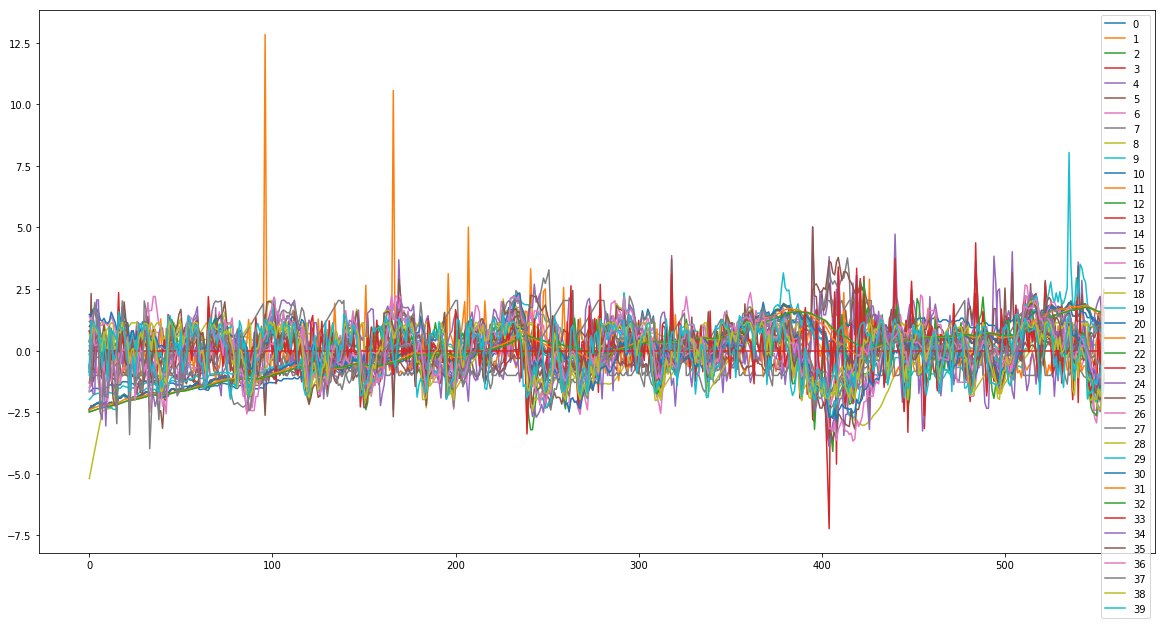

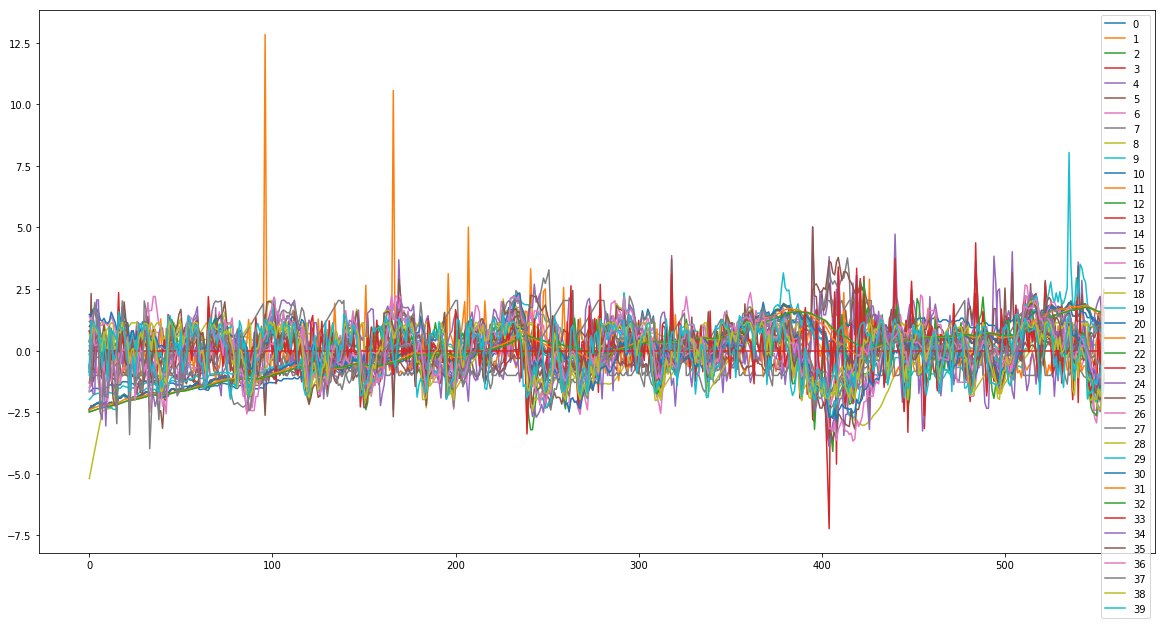

In [54]:
# observe trend in data in graph
df_std.plot(figsize=(20,10))

In [55]:
df_std.columns = cols
df_std.describe() #note that mean is 0 and std_dev is 1

,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,30_day_RSI,EMA_12,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI
count,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,...,5.550000e+02,5.550000e+02,5.550000e+02,555.0,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02
mean,6.245255e-16,-3.492702e-16,9.821973e-16,1.447891e-15,-6.241254e-17,-1.240249e-16,-3.340671e-17,-1.052211e-16,1.950392e-17,-6.601326e-15,...,4.596923e-16,1.731948e-15,1.016204e-15,0.0,1.710344e-16,1.906383e-16,-4.726950e-16,8.561720e-17,7.121431e-17,-1.600321e-18
std,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,...,1.000902e+00,1.000902e+00,1.000902e+00,0.0,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00
min,-2.427219e+00,-2.402838e+00,-2.406055e+00,-2.367225e+00,-2.388481e+00,-2.717807e+00,-2.935333e+00,-2.293327e+00,-5.188950e+00,-2.707093e+00,...,-2.857439e+00,-2.392205e+00,-2.486479e+00,0.0,-3.056592e+00,-3.151486e+00,-2.571395e+00,-3.979939e+00,-2.023903e+00,-1.974595e+00
25%,-6.498034e-01,-6.472202e-01,-6.296316e-01,-6.466677e-01,-7.069979e-01,-7.532217e-01,-6.609527e-01,-6.557920e-01,-1.529644e-01,-7.112023e-01,...,-6.234506e-01,-6.609292e-01,-6.420460e-01,0.0,-6.985263e-01,-7.146455e-01,-7.697181e-01,-6.989739e-01,-7.686955e-01,-9.221764e-01
50%,1.130475e-01,1.160457e-01,1.058389e-01,1.063380e-01,-2.317145e-01,-1.882084e-01,6.354622e-02,-1.301817e-01,1.986252e-01,1.532521e-01,...,8.284876e-02,1.488845e-01,2.238148e-01,0.0,-4.515418e-02,5.969981e-02,4.489590e-02,8.267384e-02,3.171986e-01,2.701056e-01
75%,6.149043e-01,6.192832e-01,6.161566e-01,6.141431e-01,4.854043e-01,5.266717e-01,7.111292e-01,5.614449e-01,5.676750e-01,7.202641e-01,...,7.146253e-01,5.793386e-01,6.171318e-01,0.0,7.491569e-01,7.582113e-01,7.691860e-01,6.311645e-01,8.679020e-01,8.646537e-01
max,2.023316e+00,1.957749e+00,1.959482e+00,1.943246e+00,5.026061e+00,5.012013e+00,2.666962e+00,3.765473e+00,1.542898e+00,2.020585e+00,...,2.322594e+00,1.838193e+00,1.753449e+00,0.0,2.056953e+00,1.982032e+00,2.175316e+00,2.020718e+00,1.174460e+00,1.582894e+00


,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,30_day_RSI,EMA_12,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI
count,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,...,5.550000e+02,5.550000e+02,5.550000e+02,555.0,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02
mean,6.245255e-16,-3.492702e-16,9.821973e-16,1.447891e-15,-6.241254e-17,-1.240249e-16,-3.340671e-17,-1.052211e-16,1.950392e-17,-6.601326e-15,...,4.596923e-16,1.731948e-15,1.016204e-15,0.0,1.710344e-16,1.906383e-16,-4.726950e-16,8.561720e-17,7.121431e-17,-1.600321e-18
std,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,...,1.000902e+00,1.000902e+00,1.000902e+00,0.0,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00
min,-2.427219e+00,-2.402838e+00,-2.406055e+00,-2.367225e+00,-2.388481e+00,-2.717807e+00,-2.935333e+00,-2.293327e+00,-5.188950e+00,-2.707093e+00,...,-2.857439e+00,-2.392205e+00,-2.486479e+00,0.0,-3.056592e+00,-3.151486e+00,-2.571395e+00,-3.979939e+00,-2.023903e+00,-1.974595e+00
25%,-6.498034e-01,-6.472202e-01,-6.296316e-01,-6.466677e-01,-7.069979e-01,-7.532217e-01,-6.609527e-01,-6.557920e-01,-1.529644e-01,-7.112023e-01,...,-6.234506e-01,-6.609292e-01,-6.420460e-01,0.0,-6.985263e-01,-7.146455e-01,-7.697181e-01,-6.989739e-01,-7.686955e-01,-9.221764e-01
50%,1.130475e-01,1.160457e-01,1.058389e-01,1.063380e-01,-2.317145e-01,-1.882084e-01,6.354622e-02,-1.301817e-01,1.986252e-01,1.532521e-01,...,8.284876e-02,1.488845e-01,2.238148e-01,0.0,-4.515418e-02,5.969981e-02,4.489590e-02,8.267384e-02,3.171986e-01,2.701056e-01
75%,6.149043e-01,6.192832e-01,6.161566e-01,6.141431e-01,4.854043e-01,5.266717e-01,7.111292e-01,5.614449e-01,5.676750e-01,7.202641e-01,...,7.146253e-01,5.793386e-01,6.171318e-01,0.0,7.491569e-01,7.582113e-01,7.691860e-01,6.311645e-01,8.679020e-01,8.646537e-01
max,2.023316e+00,1.957749e+00,1.959482e+00,1.943246e+00,5.026061e+00,5.012013e+00,2.666962e+00,3.765473e+00,1.542898e+00,2.020585e+00,...,2.322594e+00,1.838193e+00,1.753449e+00,0.0,2.056953e+00,1.982032e+00,2.175316e+00,2.020718e+00,1.174460e+00,1.582894e+00


In [56]:
# make time series data stationary in the mean, thus having no trend in the data
# applying log(Vt/Vt-1) on all data
df_std_log = np.log(abs(df_std[cols]/df_std[cols].shift()))

# remove first row (contains NaN because of the t-1 shift)
df_std_log = df_std_log.iloc[1:]
df_std_log.columns = data.columns
df_std_log.describe()


,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,30_day_RSI,EMA_12,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI
count,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,...,554.000000,554.000000,554.000000,0.0,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000
mean,-0.001310,-0.001044,-0.001157,-0.000949,0.001415,0.001131,0.000710,0.000096,-0.004690,-0.002269,...,-0.000405,-0.000992,-0.000876,NaN,0.001635,-0.000677,-0.001879,-0.000538,-0.000024,0.000493
std,0.517252,0.525585,0.551246,0.580999,1.275879,1.203841,1.014105,0.858766,0.639027,0.601686,...,0.862747,0.419155,0.252598,NaN,0.930301,0.958626,0.950146,1.062997,1.108241,1.249255
min,-4.450568,-3.869609,-4.979708,-6.200780,-7.376284,-4.460908,-3.615943,-5.587463,-5.828759,-4.027441,...,-5.352321,-5.400596,-2.728172,NaN,-5.231020,-3.998827,-4.606799,-5.321957,-5.087722,-7.972279
25%,-0.107296,-0.076633,-0.100438,-0.104870,-0.551367,-0.580915,-0.511741,-0.300092,-0.099636,-0.011164,...,-0.240123,-0.031783,-0.022904,NaN,-0.317289,-0.358207,-0.335987,-0.288742,-0.365666,-0.474244
50%,-0.002647,-0.002257,-0.001094,0.000255,0.000066,0.018476,-0.001904,0.047594,-0.008021,0.000000,...,0.020127,-0.002789,-0.004431,NaN,0.000000,-0.012804,-0.004731,0.011535,-0.003243,-0.071156
75%,0.105674,0.087183,0.104580,0.127408,0.515716,0.560944,0.458670,0.303081,0.085453,0.000000,...,0.259024,0.040458,0.024997,NaN,0.318177,0.332760,0.322010,0.314498,0.382123,0.351882
max,2.723830,3.469542,4.264000,5.958336,7.316076,4.533647,4.574561,5.957292,5.451186,5.872856,...,4.941819,5.061789,2.986508,NaN,4.234012,4.226363,4.200942,6.109995,5.090163,8.497174


,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,30_day_RSI,EMA_12,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI
count,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,...,554.000000,554.000000,554.000000,0.0,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000
mean,-0.001310,-0.001044,-0.001157,-0.000949,0.001415,0.001131,0.000710,0.000096,-0.004690,-0.002269,...,-0.000405,-0.000992,-0.000876,NaN,0.001635,-0.000677,-0.001879,-0.000538,-0.000024,0.000493
std,0.517252,0.525585,0.551246,0.580999,1.275879,1.203841,1.014105,0.858766,0.639027,0.601686,...,0.862747,0.419155,0.252598,NaN,0.930301,0.958626,0.950146,1.062997,1.108241,1.249255
min,-4.450568,-3.869609,-4.979708,-6.200780,-7.376284,-4.460908,-3.615943,-5.587463,-5.828759,-4.027441,...,-5.352321,-5.400596,-2.728172,NaN,-5.231020,-3.998827,-4.606799,-5.321957,-5.087722,-7.972279
25%,-0.107296,-0.076633,-0.100438,-0.104870,-0.551367,-0.580915,-0.511741,-0.300092,-0.099636,-0.011164,...,-0.240123,-0.031783,-0.022904,NaN,-0.317289,-0.358207,-0.335987,-0.288742,-0.365666,-0.474244
50%,-0.002647,-0.002257,-0.001094,0.000255,0.000066,0.018476,-0.001904,0.047594,-0.008021,0.000000,...,0.020127,-0.002789,-0.004431,NaN,0.000000,-0.012804,-0.004731,0.011535,-0.003243,-0.071156
75%,0.105674,0.087183,0.104580,0.127408,0.515716,0.560944,0.458670,0.303081,0.085453,0.000000,...,0.259024,0.040458,0.024997,NaN,0.318177,0.332760,0.322010,0.314498,0.382123,0.351882
max,2.723830,3.469542,4.264000,5.958336,7.316076,4.533647,4.574561,5.957292,5.451186,5.872856,...,4.941819,5.061789,2.986508,NaN,4.234012,4.226363,4.200942,6.109995,5.090163,8.497174


In [57]:
df_std_log['Down'] = 0
df_std_log['Up'] = 0
df_std_log.loc[df_std_log['Close'] >= 0, 'Up'] = 1
df_std_log.loc[df_std_log['Close'] < 0, 'Down'] = 1
#df_std = df_std_log
df_std_log.describe()

,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI,Down,Up
count,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,...,554.000000,0.0,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000
mean,-0.001310,-0.001044,-0.001157,-0.000949,0.001415,0.001131,0.000710,0.000096,-0.004690,-0.002269,...,-0.000876,NaN,0.001635,-0.000677,-0.001879,-0.000538,-0.000024,0.000493,0.496390,0.503610
std,0.517252,0.525585,0.551246,0.580999,1.275879,1.203841,1.014105,0.858766,0.639027,0.601686,...,0.252598,NaN,0.930301,0.958626,0.950146,1.062997,1.108241,1.249255,0.500439,0.500439
min,-4.450568,-3.869609,-4.979708,-6.200780,-7.376284,-4.460908,-3.615943,-5.587463,-5.828759,-4.027441,...,-2.728172,NaN,-5.231020,-3.998827,-4.606799,-5.321957,-5.087722,-7.972279,0.000000,0.000000
25%,-0.107296,-0.076633,-0.100438,-0.104870,-0.551367,-0.580915,-0.511741,-0.300092,-0.099636,-0.011164,...,-0.022904,NaN,-0.317289,-0.358207,-0.335987,-0.288742,-0.365666,-0.474244,0.000000,0.000000
50%,-0.002647,-0.002257,-0.001094,0.000255,0.000066,0.018476,-0.001904,0.047594,-0.008021,0.000000,...,-0.004431,NaN,0.000000,-0.012804,-0.004731,0.011535,-0.003243,-0.071156,0.000000,1.000000
75%,0.105674,0.087183,0.104580,0.127408,0.515716,0.560944,0.458670,0.303081,0.085453,0.000000,...,0.024997,NaN,0.318177,0.332760,0.322010,0.314498,0.382123,0.351882,1.000000,1.000000
max,2.723830,3.469542,4.264000,5.958336,7.316076,4.533647,4.574561,5.957292,5.451186,5.872856,...,2.986508,NaN,4.234012,4.226363,4.200942,6.109995,5.090163,8.497174,1.000000,1.000000


,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI,Down,Up
count,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,...,554.000000,0.0,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000
mean,-0.001310,-0.001044,-0.001157,-0.000949,0.001415,0.001131,0.000710,0.000096,-0.004690,-0.002269,...,-0.000876,NaN,0.001635,-0.000677,-0.001879,-0.000538,-0.000024,0.000493,0.496390,0.503610
std,0.517252,0.525585,0.551246,0.580999,1.275879,1.203841,1.014105,0.858766,0.639027,0.601686,...,0.252598,NaN,0.930301,0.958626,0.950146,1.062997,1.108241,1.249255,0.500439,0.500439
min,-4.450568,-3.869609,-4.979708,-6.200780,-7.376284,-4.460908,-3.615943,-5.587463,-5.828759,-4.027441,...,-2.728172,NaN,-5.231020,-3.998827,-4.606799,-5.321957,-5.087722,-7.972279,0.000000,0.000000
25%,-0.107296,-0.076633,-0.100438,-0.104870,-0.551367,-0.580915,-0.511741,-0.300092,-0.099636,-0.011164,...,-0.022904,NaN,-0.317289,-0.358207,-0.335987,-0.288742,-0.365666,-0.474244,0.000000,0.000000
50%,-0.002647,-0.002257,-0.001094,0.000255,0.000066,0.018476,-0.001904,0.047594,-0.008021,0.000000,...,-0.004431,NaN,0.000000,-0.012804,-0.004731,0.011535,-0.003243,-0.071156,0.000000,1.000000
75%,0.105674,0.087183,0.104580,0.127408,0.515716,0.560944,0.458670,0.303081,0.085453,0.000000,...,0.024997,NaN,0.318177,0.332760,0.322010,0.314498,0.382123,0.351882,1.000000,1.000000
max,2.723830,3.469542,4.264000,5.958336,7.316076,4.533647,4.574561,5.957292,5.451186,5.872856,...,2.986508,NaN,4.234012,4.226363,4.200942,6.109995,5.090163,8.497174,1.000000,1.000000


In [58]:
df_std = df_std[1:]
df_std['Up'] = df_std_log['Up']
df_std['Down'] = df_std_log['Down']

In [59]:
df_std.index = range(0,len(df_std))


In [60]:
#Blasting the outliers
from scipy import stats
z = pd.DataFrame(abs(stats.zscore(df_std,axis = 1)))
z.columns = df_std.columns
df_std = df_std[(z < 3).all(axis=1)]

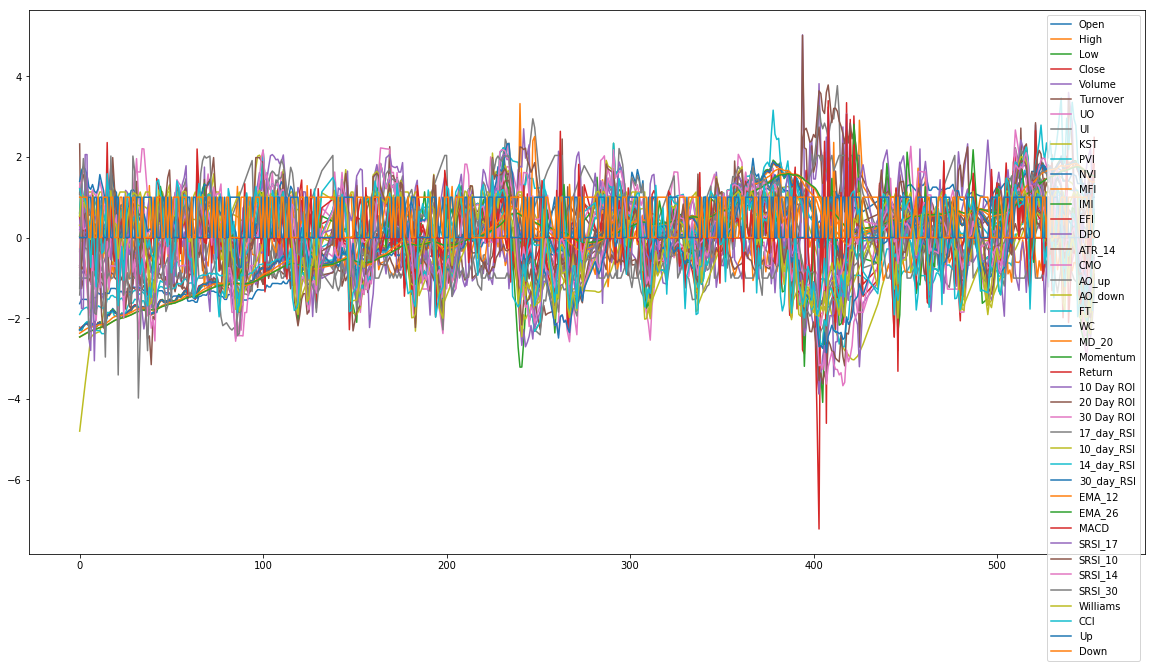

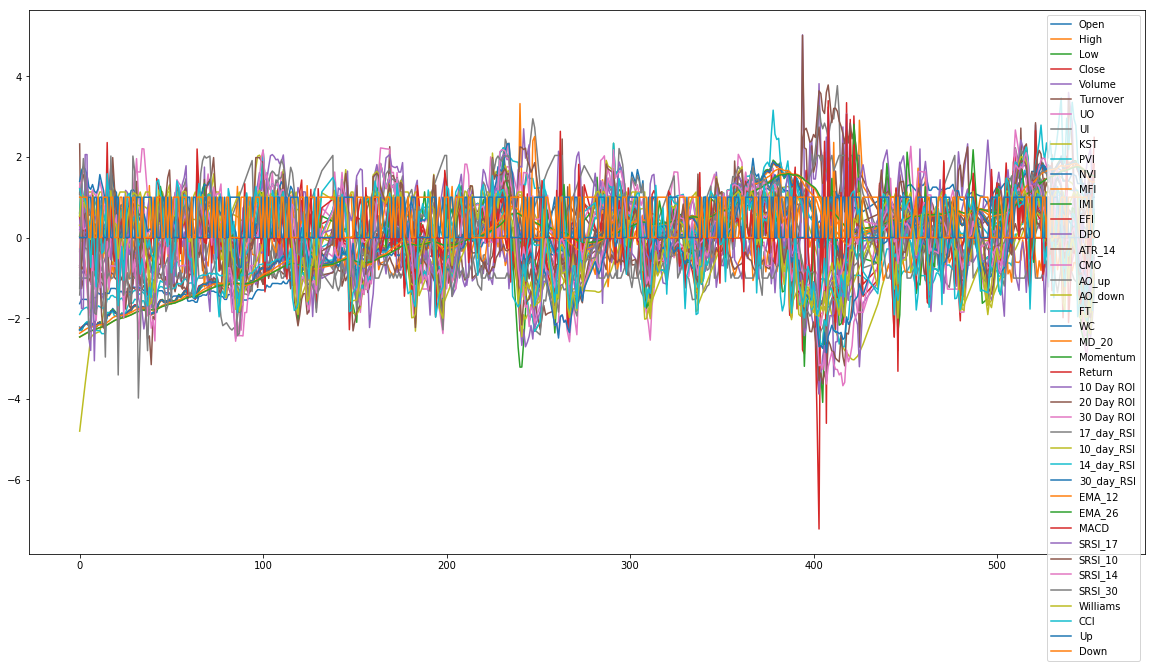

In [61]:
df_std.plot(figsize=(20,10))

In [62]:
df_std.head()

,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI,Up,Down
0,-2.220622,-2.243159,-2.283645,-2.304627,0.498111,2.320468,0.033989,-1.424278,-4.800474,-2.295444,...,-2.465160,0.0,-0.288650,-0.739612,-0.939947,-1.261600,0.522713,1.206202,0,1
1,-2.313641,-2.257637,-2.275619,-2.222260,-0.906381,-1.268468,0.500309,-0.641018,-4.399847,-2.295444,...,-2.439359,0.0,-1.761067,-0.775647,1.416492,1.145878,1.052308,0.998105,0,1
2,-2.210557,-2.208598,-2.201653,-2.181221,-0.822124,-1.031450,0.557553,-0.349838,-4.002618,-2.195889,...,-2.412450,0.0,-1.761067,0.414953,0.209205,1.958087,1.029002,1.010992,0,1
3,-2.152233,-2.151894,-2.137592,-2.153932,-0.053730,0.038479,0.261256,-0.254148,-3.622997,-2.129694,...,-2.385525,0.0,2.056953,0.590949,0.224088,1.446524,0.768855,0.910008,0,1
4,-2.116824,-2.121519,-2.105345,-2.135883,1.347550,0.896425,0.047229,-0.287127,-3.260520,-2.085911,...,-2.359266,0.0,2.056953,0.620112,0.296040,0.115123,0.687595,0.781648,0,1


,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI,Up,Down
0,-2.220622,-2.243159,-2.283645,-2.304627,0.498111,2.320468,0.033989,-1.424278,-4.800474,-2.295444,...,-2.465160,0.0,-0.288650,-0.739612,-0.939947,-1.261600,0.522713,1.206202,0,1
1,-2.313641,-2.257637,-2.275619,-2.222260,-0.906381,-1.268468,0.500309,-0.641018,-4.399847,-2.295444,...,-2.439359,0.0,-1.761067,-0.775647,1.416492,1.145878,1.052308,0.998105,0,1
2,-2.210557,-2.208598,-2.201653,-2.181221,-0.822124,-1.031450,0.557553,-0.349838,-4.002618,-2.195889,...,-2.412450,0.0,-1.761067,0.414953,0.209205,1.958087,1.029002,1.010992,0,1
3,-2.152233,-2.151894,-2.137592,-2.153932,-0.053730,0.038479,0.261256,-0.254148,-3.622997,-2.129694,...,-2.385525,0.0,2.056953,0.590949,0.224088,1.446524,0.768855,0.910008,0,1
4,-2.116824,-2.121519,-2.105345,-2.135883,1.347550,0.896425,0.047229,-0.287127,-3.260520,-2.085911,...,-2.359266,0.0,2.056953,0.620112,0.296040,0.115123,0.687595,0.781648,0,1


In [63]:
cols = df_std.columns
cols = cols[::-1]

In [64]:
dataset = df_std[cols]
dataset = dataset.astype(float)

In [65]:
dataset.columns[[0,1]]

Index(['Down', 'Up'], dtype='object')

Index(['Down', 'Up'], dtype='object')

In [66]:
class DataProvider():
    def __init__(self, dataset, batch_size):
        self.ctr = 0
        self.batch_size = batch_size
        
        # split training/testing according to ratio (default 0.8)
        train_set_size = int(len(dataset) * 0.8)
        test_set_size = len(dataset) - train_set_size

        self.training_dataset = dataset[:train_set_size]
        self.testing_dataset  = dataset[train_set_size:]

        # split labels
        self.training_labels = self.training_dataset[self.training_dataset.columns[:2]]
        self.training_dataset = self.training_dataset[self.training_dataset.columns[2:]]
        self.testing_labels = self.testing_dataset[self.testing_dataset.columns[:2]]
        self.testing_dataset = self.testing_dataset[self.testing_dataset.columns[2:]]
        
    def next_batch_train(self):
        begin_position = self.ctr * self.batch_size
        
        if begin_position + self.batch_size >= len(self.training_dataset):
            data = self.training_dataset[begin_position:]
            label = self.training_labels[begin_position:]
            self.ctr = 0
        else:
            data = self.training_dataset[begin_position:begin_position + self.batch_size]
            label = self.training_labels[begin_position:begin_position + self.batch_size]
            self.ctr += 1
        
        return data.values, label.values
    
    def get_test_data(self):
        return self.testing_dataset.values, self.testing_labels.values

# Create Model

In [67]:
# config
no_of_iterations = 50000
batch_size = 200 #?

## model config
hidden_layer1_neurons = 60
hidden_layer2_neurons = 30
hidden_layer3_neurons = 20

# DropOut
pkeep_train = 0.75 #?

# number of features
input_dim = len(dataset.columns) - 2

# number of output classes
output_dim = 2

In [68]:
data_provider = DataProvider(dataset, batch_size)

In [69]:
# custom decorator for Model
#  - to make functions execute only the first time (every time the functions are called, the graph would be extended by new code)
#  - name the variable scope for TF visualization
def define_scope(function, scope=None):
    attribute = '_cache_' + function.__name__

    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)

    return decorator

Model description:
Model consists of 3 hidden layers + 1 softmax output layer.
Incorporates shootout while training to make inidividual neurons more independent on other layers and perform better.
Incorporates learning rate decay.

In [70]:
class Model():
    def __init__(self, data, label, learning_rate):
        self.data = data
        self.label = label
        self.learning_rate = learning_rate
        self.prediction
        self.optimize
        
    @define_scope
    def prediction(self):        
        # weights + biases
        w1 = tf.Variable(tf.truncated_normal([input_dim, hidden_layer1_neurons], stddev=0.0001))
        b1 = tf.Variable(tf.ones([hidden_layer1_neurons]))

        w2 = tf.Variable(tf.truncated_normal([hidden_layer1_neurons, hidden_layer2_neurons], stddev=0.0001))
        b2 = tf.Variable(tf.ones([hidden_layer2_neurons]))

        w3 = tf.Variable(tf.truncated_normal([hidden_layer2_neurons, hidden_layer3_neurons], stddev=0.0001))
        b3 = tf.Variable(tf.ones([hidden_layer3_neurons]))
        
        w4 = tf.Variable(tf.truncated_normal([hidden_layer3_neurons, output_dim], stddev=0.0001))
        b4 = tf.Variable(tf.ones([output_dim]))
        
        # hidden layers
        Y1 = tf.nn.relu(tf.matmul(self.data, w1) + b1)
        Y1d = tf.nn.dropout(Y1, pkeep)
        Y2 = tf.nn.relu(tf.matmul(Y1, w2) + b2)
        Y2d = tf.nn.dropout(Y2, pkeep)
        Y3 = tf.nn.relu(tf.matmul(Y2, w3) + b3)
        Y3d = tf.nn.dropout(Y3, pkeep)
        
        # softmax layer
        return tf.nn.softmax(tf.matmul(Y3d, w4) + b4)
    
    @define_scope
    def optimize(self):
        # compute cost function and minimize
        cross_entropy = -tf.reduce_sum(self.label * tf.log(self.prediction))
        return tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy), cross_entropy
    
    @define_scope
    def error(self):
        mistakes = tf.equal(tf.argmax(self.label, 1), tf.argmax(self.prediction, 1))
        accuracy = tf.reduce_mean(tf.cast(mistakes, tf.float32))
        loss = -tf.reduce_sum(self.label * tf.log(self.prediction))
        return accuracy, loss

In [71]:
# data feed
X = tf.placeholder(tf.float32, [None, input_dim])
_Y = tf.placeholder(tf.float32, [None, output_dim])
learning_rate = tf.placeholder(tf.float32)

# DropOut: feed in 1 when testing, 0.75 when training
pkeep = tf.placeholder(tf.float32)

In [72]:
model = Model(data=X, label=_Y, learning_rate=learning_rate)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [73]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

accuracy = []
_loss = []
for i in range(no_of_iterations):
    # execute training step
    # optimizer learning rate decay
    lrmax = 0.001
    lrmin = 0.00001
    lr = lrmin + (lrmax - lrmin) * math.exp(-i / 2000)
    
    data_batch, label_batch = data_provider.next_batch_train()
    sess.run(model.optimize, feed_dict={X: data_batch, _Y: label_batch, learning_rate:lr, pkeep: pkeep_train})
    
    if i % 500 == 0:
        # compute accuracy
        data_batch, label_batch = data_provider.get_test_data()
        acc, loss = sess.run(model.error, feed_dict={X: data_batch, _Y: label_batch, pkeep: 1})
        accuracy.append(acc)
        _loss.append(loss)
        print('---epoch {}---\naccuracy: {}, loss: {}'.format(i // 500, acc, loss))

print('Training finished')

---epoch 0---
accuracy: 0.44329896569252014, loss: 67.48041534423828
---epoch 0---
accuracy: 0.44329896569252014, loss: 67.48041534423828
---epoch 1---
accuracy: 0.5463917255401611, loss: 69.70818328857422
---epoch 1---
accuracy: 0.5463917255401611, loss: 69.70818328857422
---epoch 2---
accuracy: 0.5360824465751648, loss: 70.85212707519531
---epoch 2---
accuracy: 0.5360824465751648, loss: 70.85212707519531
---epoch 3---
accuracy: 0.5360824465751648, loss: 71.29964447021484
---epoch 3---
accuracy: 0.5360824465751648, loss: 71.29964447021484
---epoch 4---
accuracy: 0.5463917255401611, loss: 71.08878326416016
---epoch 4---
accuracy: 0.5463917255401611, loss: 71.08878326416016
---epoch 5---
accuracy: 0.5463917255401611, loss: 71.21565246582031
---epoch 5---
accuracy: 0.5463917255401611, loss: 71.21565246582031
---epoch 6---
accuracy: 0.5463917255401611, loss: 71.31160736083984
---epoch 6---
accuracy: 0.5463917255401611, loss: 71.31160736083984
---epoch 7---
accuracy: 0.5463917255401611, lo

---epoch 60---
accuracy: 0.5463917255401611, loss: 71.29994201660156
---epoch 60---
accuracy: 0.5463917255401611, loss: 71.29994201660156
---epoch 61---
accuracy: 0.5463917255401611, loss: 71.29229736328125
---epoch 61---
accuracy: 0.5463917255401611, loss: 71.29229736328125
---epoch 62---
accuracy: 0.5463917255401611, loss: 71.30095672607422
---epoch 62---
accuracy: 0.5463917255401611, loss: 71.30095672607422
---epoch 63---
accuracy: 0.5463917255401611, loss: 71.31012725830078
---epoch 63---
accuracy: 0.5463917255401611, loss: 71.31012725830078
---epoch 64---
accuracy: 0.5463917255401611, loss: 71.2910385131836
---epoch 64---
accuracy: 0.5463917255401611, loss: 71.2910385131836
---epoch 65---
accuracy: 0.5463917255401611, loss: 71.2993392944336
---epoch 65---
accuracy: 0.5463917255401611, loss: 71.2993392944336
---epoch 66---
accuracy: 0.5463917255401611, loss: 71.28937530517578
---epoch 66---
accuracy: 0.5463917255401611, loss: 71.28937530517578
---epoch 67---
accuracy: 0.54639172554

In [74]:
# accuracy on test data
data_batch, label_batch = data_provider.get_test_data()
acc, loss = sess.run(model.error, feed_dict={X: data_batch, _Y: label_batch, pkeep: 1})
print('Test: accuracy={}, loss={}'.format(acc, loss))

Test: accuracy=0.5463917255401611, loss=71.26300048828125
Test: accuracy=0.5463917255401611, loss=71.26300048828125


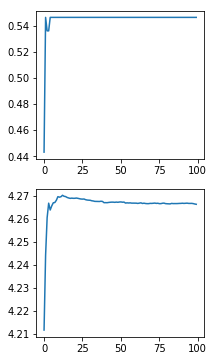

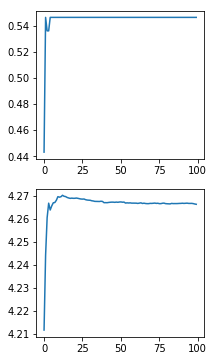

In [75]:
plt.figure(figsize=(3,6))

# accuracy
plt.subplot(211)
plt.plot(accuracy)

# loss
plt.subplot(212)
plt.plot(np.log(_loss))

plt.show()